<a href="https://colab.research.google.com/github/mingmingbupt/tensorflow/blob/master/tf_keras_regression_hp_search_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

TensorFlow 2.x selected.
2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
# 我们使用sklearn里面的 RandomizedSearchCV 来实现我们超参数的随机化搜索.需要实现下面3步
# 1. 转化为sklearn的model。我们要使用这个函数呢，因为这个是sklearn里面的一个函数，
#   所以呢，我们要先把我们的tf-kerasmodel转成sklean的model.通过KerasRegressor或者KerasClassifier实现转换
# 2. 定义参数集合。转成skleanr的model以后我们就可以定义参数集合，使用RandomizedSearchCV去搜索参数
# 3. 搜索参数。
from keras.wrappers.scikit_learn import KerasRegressor
def build_model(hidden_layers = 1, # 中间层的层数
                layer_size = 30, #默认就是30，表示如果没有参数传进来的时候的默认值就是30，如果传进来其他值得话 就会把这个数覆盖
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    # 为什么我们要把第一个add跟for循环里面的add分开呢，因为呢第一层需要设置一个输入shape，而其他的隐含层不需要，因为其他的隐含层的输入都是上面隐藏层的输出
    # 所以说他可以自己推导出来，只有第一个不知道输入的shape是多大的
    model.add(keras.layers.Dense(layer_size, activation='relu',input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    # 因为learning_rate是可变的，所以这里optimizer是自定义的
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

#1.  首先使用build_model，定义一个keras model，然后调用函数KerasClassifier或者KerasRegressor把keras model 封装成一个 sklearn 支持的 model
sklearn_model = KerasRegressor( # KerasClassifier 和 KerasRegressor
    build_fn = build_model) # 把我们定义的keras model 转成sklean model，然后这个KerasRegressor函数呢，接受的参数是一个bulid_fn
                 # bulid_fn呢，也就是一个函数，这个函数返回的是一个搭建好的tf keras model
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

#2. 因为这已经是一个独立的sklearn的函数了，所以我们依然可以调用fit函数，因为在sklearn里他也支持这个fit函数，并记录返回值到history里面
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks) #然后把callback也传进来

Using TensorFlow backend.


Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 86us/sample - loss: 1.6086 - val_loss: 0.8110
Epoch 2/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.7213 - val_loss: 0.7229
Epoch 3/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.6495 - val_loss: 0.6674
Epoch 4/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5995 - val_loss: 0.6149
Epoch 5/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.5599 - val_loss: 0.5816
Epoch 6/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5292 - val_loss: 0.5503
Epoch 7/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5048 - val_loss: 0.5230
Epoch 8/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4851 - val_loss: 0.5067
Epoch 9/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4735 - val_l

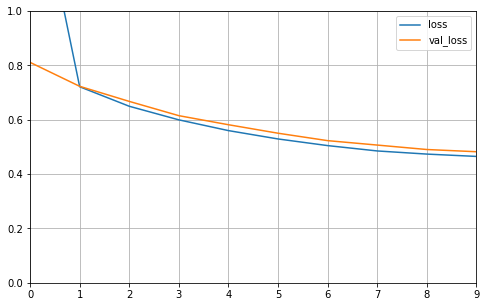

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [0]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b x在(a,b)之间每个值呢 取值的概率就是这样算出来的

param_distribution = {
    "hidden_layers":[1, 2, 3, 4], #隐层个数
    "layer_size": np.arange(1, 100), #1,2,3 一直到00
    "learning_rate": reciprocal(1e-4, 1e-2), 
                # learngingrate我希望他的取值是一个连续取值，他是在一个连续空间内进行取值，我定义他的最大值最小值就可以啦
                # 因此呢 我使用一个分布来生成learningrate使用一个分布生成连续的值，这个分布呢，是reciprocal的一个分布
}

from sklearn.model_selection import RandomizedSearchCV

#初始化这个对象 
random_search_cv = RandomizedSearchCV(sklearn_model, # 之前定义的sklearn形式的model
                                      param_distribution, # 参数分布
                                      n_iter = 10, # 我从这个param_distribution中sample出来多少个参数集合，这里生成10
                                      cv = 3, # 训练集分成n份，n-1训练，最后一份验证.n就是cv的值，可以修改
                                      n_jobs = 1) # 有多少任务在并行处理
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证.
# 最后还会用所有数据训练一次

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 97us/sample - loss: 1.2357 - val_loss: 0.7356
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.6631 - val_loss: 0.6412
Epoch 3/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.5840 - val_loss: 0.5854
Epoch 4/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.5349 - val_loss: 0.5366
Epoch 5/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4992 - val_loss: 0.5068
Epoch 6/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4713 - val_loss: 0.4832
Epoch 7/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.4522 - val_loss: 0.4604
Epoch 8/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4331 - val_loss: 0.4417
Epoch 9/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4158 - val_loss: 0.436

In [0]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 44, 'learning_rate': 0.0009577195482517434}
-0.38287415603026553


In [0]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 30us/sample - loss: 0.3790


0.3790317230446394

In [8]:
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2, size = 10) # 每个数都是在1e-4 和 1e-2之间

array([0.00027773, 0.0020727 , 0.00994371, 0.0029788 , 0.00151346,
       0.0030166 , 0.0011623 , 0.00015027, 0.00028363, 0.00041566])